LDA for Amino Acid Data
==

This notebook performs LDA on the amino acid data to look for peak signatures of the various AAs.

In [434]:
import numpy as np
import pylab as plt
import pymzml
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/simon/git/inklda/code/')
from lda import LDA


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
from lda import LDA_Feature_Extractor as LDAF
fe = LDAF(aa_file,use_scans='even')
fe.make_corpus()

Found 1141 documents
Removing 391 words


In [442]:
from lda import LDA
l = LDA(fe.corpus,K=100)

l.gibbs_iteration(200,burn=True)
l.gibbs_iteration(500,burn=False)

Sample 0 of 200 (Burn is True)
Sample 1 of 200 (Burn is True)
Sample 2 of 200 (Burn is True)
Sample 3 of 200 (Burn is True)
Sample 4 of 200 (Burn is True)
Sample 5 of 200 (Burn is True)
Sample 6 of 200 (Burn is True)
Sample 7 of 200 (Burn is True)
Sample 8 of 200 (Burn is True)
Sample 9 of 200 (Burn is True)
Sample 10 of 200 (Burn is True)
Sample 11 of 200 (Burn is True)
Sample 12 of 200 (Burn is True)
Sample 13 of 200 (Burn is True)
Sample 14 of 200 (Burn is True)
Sample 15 of 200 (Burn is True)
Sample 16 of 200 (Burn is True)
Sample 17 of 200 (Burn is True)
Sample 18 of 200 (Burn is True)
Sample 19 of 200 (Burn is True)
Sample 20 of 200 (Burn is True)
Sample 21 of 200 (Burn is True)
Sample 22 of 200 (Burn is True)
Sample 23 of 200 (Burn is True)
Sample 24 of 200 (Burn is True)
Sample 25 of 200 (Burn is True)
Sample 26 of 200 (Burn is True)
Sample 27 of 200 (Burn is True)
Sample 28 of 200 (Burn is True)
Sample 29 of 200 (Burn is True)
Sample 30 of 200 (Burn is True)
Sample 31 of 200 (

In [443]:
from ink_functions import ImagingGrid
ig = ImagingGrid()

The following cell looks to see if peaks corresponding to some Amino acids appear and plots where they appear

In [446]:
amino_acids = {}
with open('/Users/simon/Dropbox/MS_Ink_Data/Amino Acids/acid_ions.csv','r') as f:
    for line in f:
        split_line = line.split(',')
        amino_acids[split_line[0]] = float(split_line[1])
#     = {'histidine':156.0678,'arginine':175.1190,'proline':116.0706,
#                'phenylalnine':166.0683,'leucine':132.1019,'methionine':150.0583}
print amino_acids

{'L-Glutamic Acid': 148.0604, 'L-Aspartatic Acid': 134.0448, 'L-Asparagine': 133.0608, 'Hydroxy-L-Proline': 132.0655, 'L-Threonine': 120.0655, 'L-Lysine': 147.1128, 'L-Valine': 118.0863, 'L-Histidine': 156.0768, 'L-Phenylalanine': 166.0863, 'L-Cysteine': 122.027, 'L-Serine': 106.0499, 'L-Arginine2': 175.119, 'L-Glutamine': 147.0764, 'L-Homoserine': 120.0655, 'L-Arginine': 175.119, 'L-Tyrosine*': 182.0812, 'D-Arginine2': 175.119, 'L-Ornithine': 133.0972, 'L-isoleucine': 132.1019, 'L-Alanine': 90.055, 'L-Cystine*': 241.0311, 'Glycine': 76.039, 'L-Leucine': 132.1019, 'L-Methionine': 150.0583, 'L-Tryptophan': 205.0972, 'L-Proline': 116.0706}


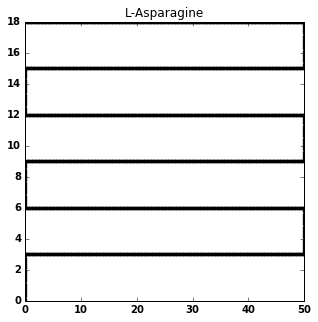

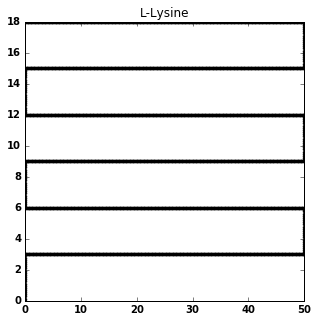

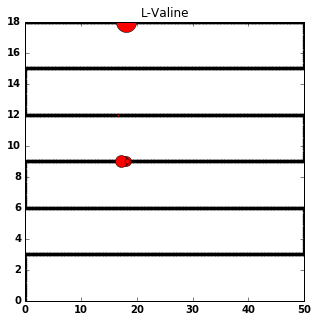

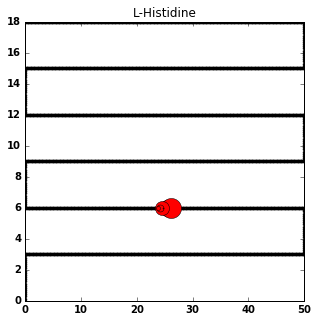

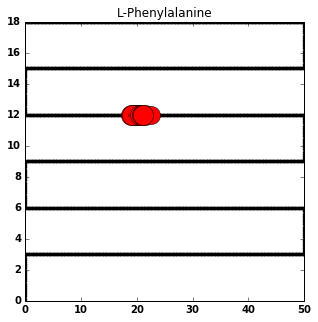

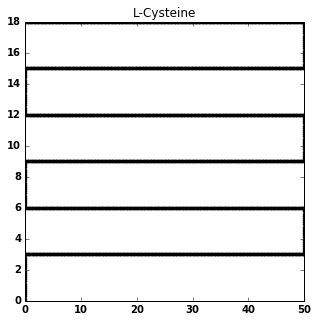

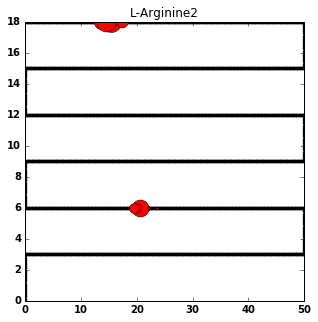

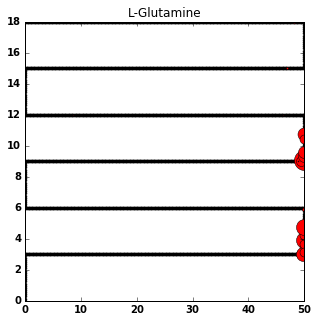

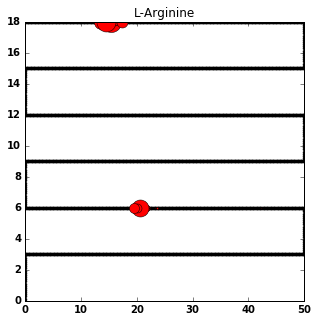

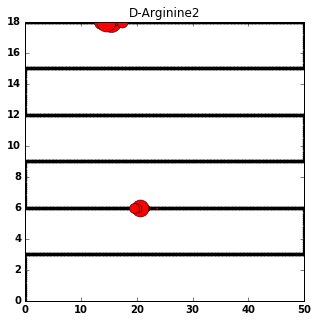

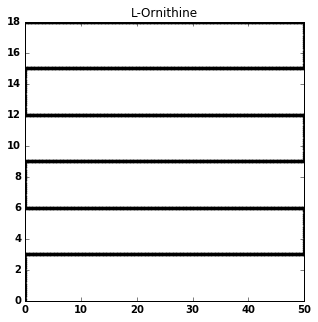

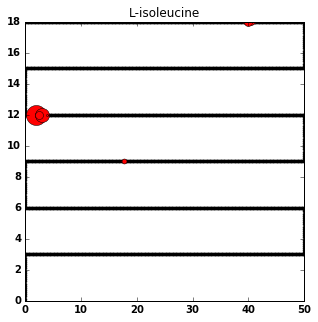

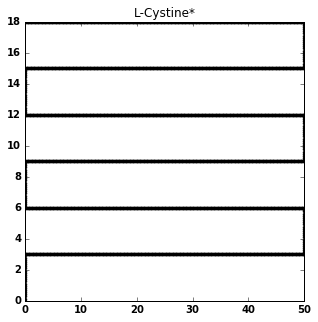

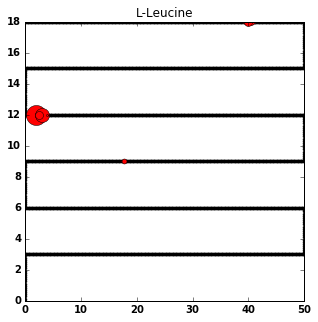

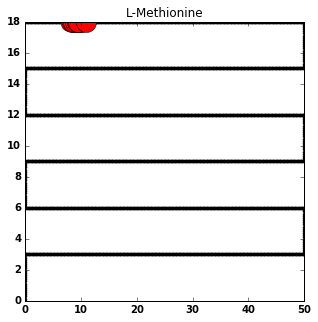

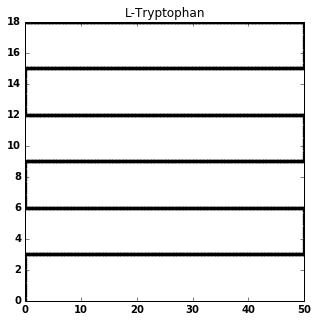

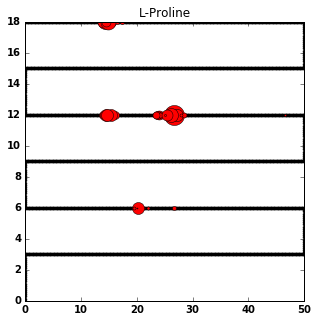

In [448]:
# Check with the amino acids
for a in amino_acids:
    intensity_vector = {}
    closest_idx = np.abs(amino_acids[a] - np.array(fe.word_masses)).argmin()
    w = fe.word_names[closest_idx]
    if 1e6*np.abs(amino_acids[a] - fe.word_masses[closest_idx])/amino_acids[a] < 50:
        for doc in fe.corpus:
            if w in fe.corpus[doc]:
                intensity_vector[doc] = fe.corpus[doc][w]
        ig.plot(vals=intensity_vector,figsize=(5,5),max_marker_size=20)
        plt.title(a)

Find the best topics for each of the amino acids that *should* be there

In [460]:
best_topics = {}
pmth = l.get_post_mean_theta()
lda_words = []
for w in l.word_index:
    lda_words.append(w)
for a in amino_acids:
    # find the best word in the lda
    closest_idx = np.abs(amino_acids[a] - np.array([float(w) for w in lda_words])).argmin()
    if 1e6*np.abs(amino_acids[a] - float(lda_words[closest_idx]))/amino_acids[a] < 50:
        word = lda_words[closest_idx]
        print "{} -> {} ({})".format(a,word,amino_acids[a])
        word_pos = l.word_index[word]
        best_topics[a] = l.topic_word_counts[:,word_pos].argmax()
    
    
for a in best_topics:
    print "{} -> {}".format(a,best_topics[a])

L-Valine -> 118.085411716 (118.0863)
L-Histidine -> 156.079996601 (156.0768)
L-Phenylalanine -> 166.084010127 (166.0863)
L-Arginine2 -> 175.120361911 (175.119)
L-Glutamine -> 147.080243151 (147.0764)
L-Arginine -> 175.120361911 (175.119)
D-Arginine2 -> 175.120361911 (175.119)
L-isoleucine -> 132.100106364 (132.1019)
L-Leucine -> 132.100106364 (132.1019)
L-Methionine -> 150.054998045 (150.0583)
L-Proline -> 116.068914362 (116.0706)
L-Methionine -> 45
L-Leucine -> 57
L-Valine -> 88
L-Arginine -> 60
L-Histidine -> 50
L-Proline -> 81
D-Arginine2 -> 60
L-Phenylalanine -> 37
L-isoleucine -> 57
L-Arginine2 -> 60
L-Glutamine -> 23


Plot these topics...

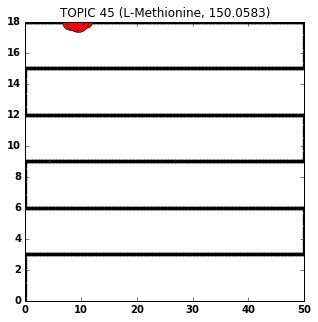

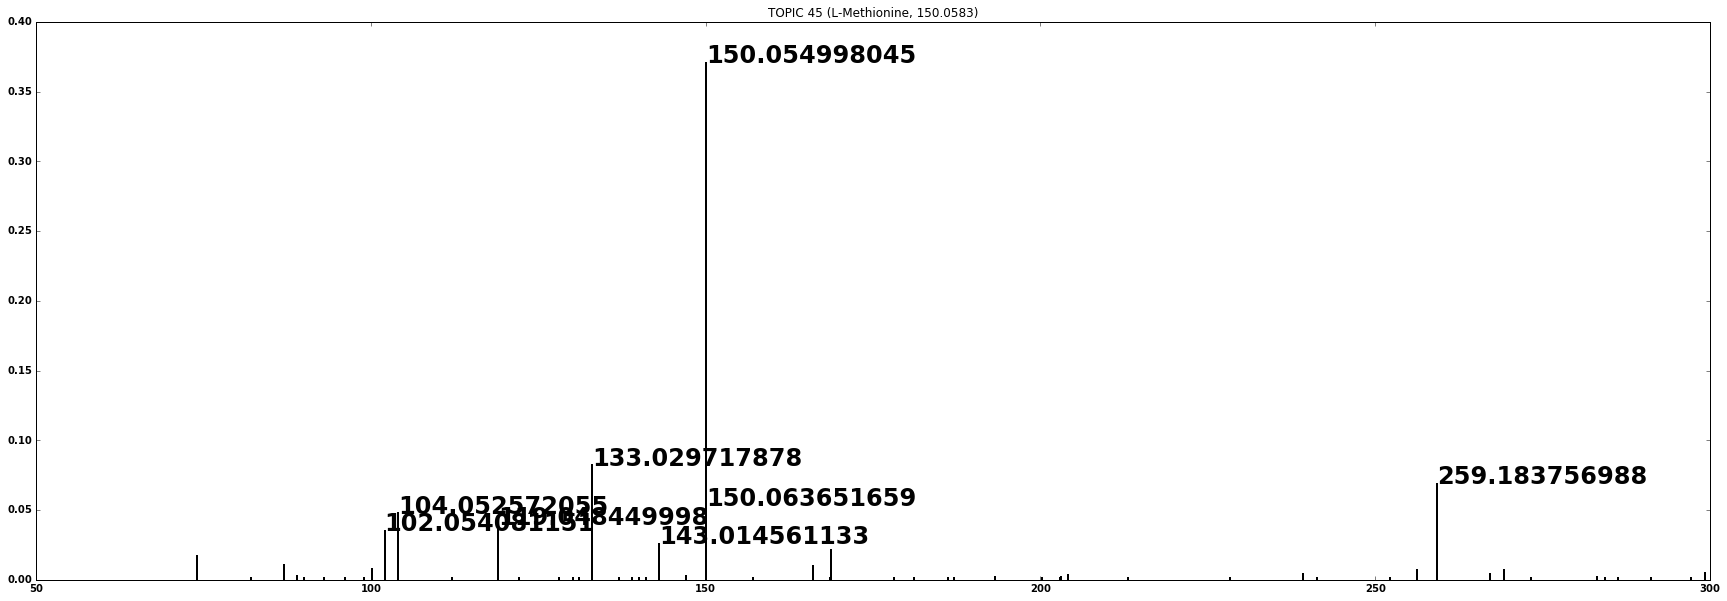

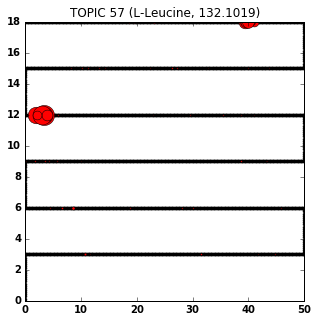

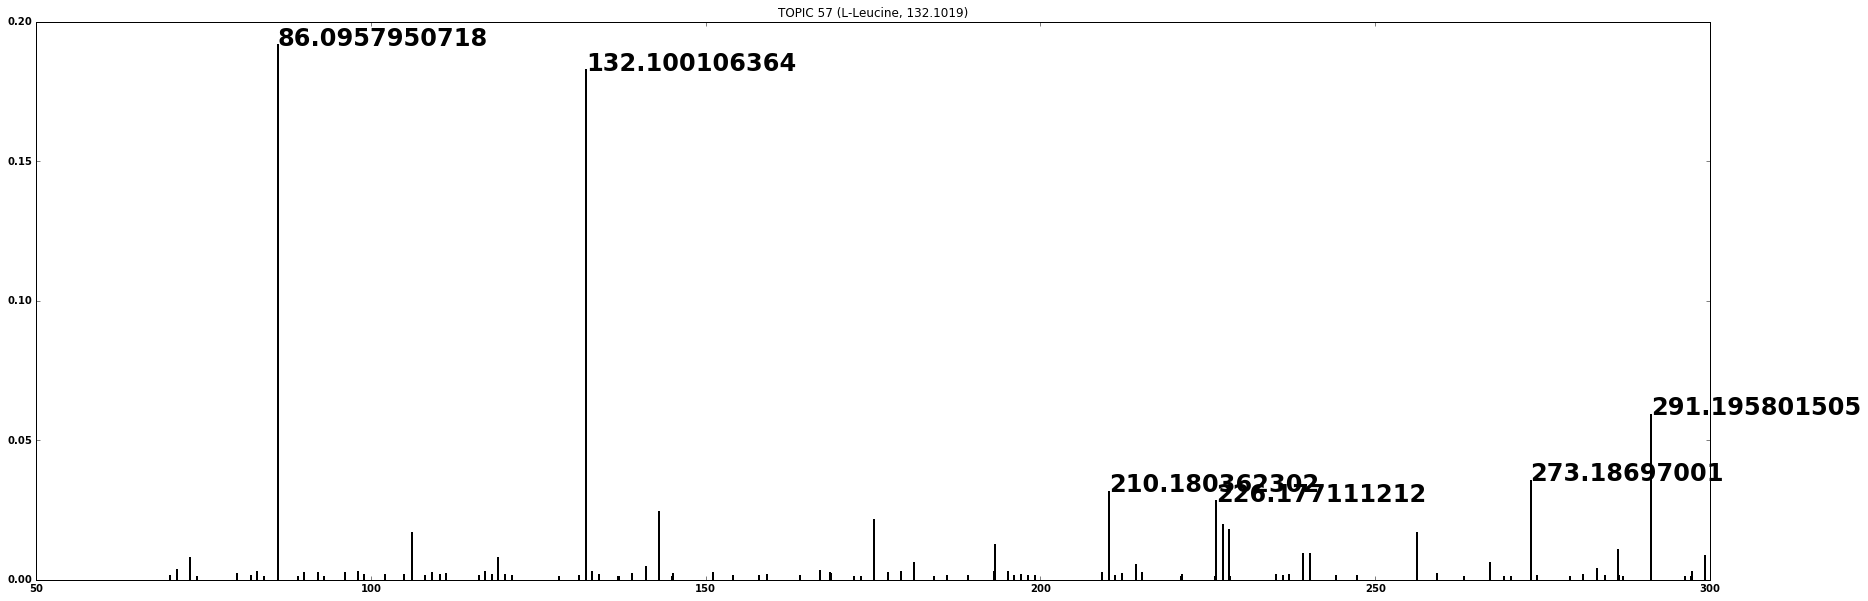

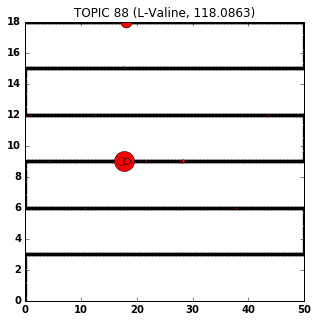

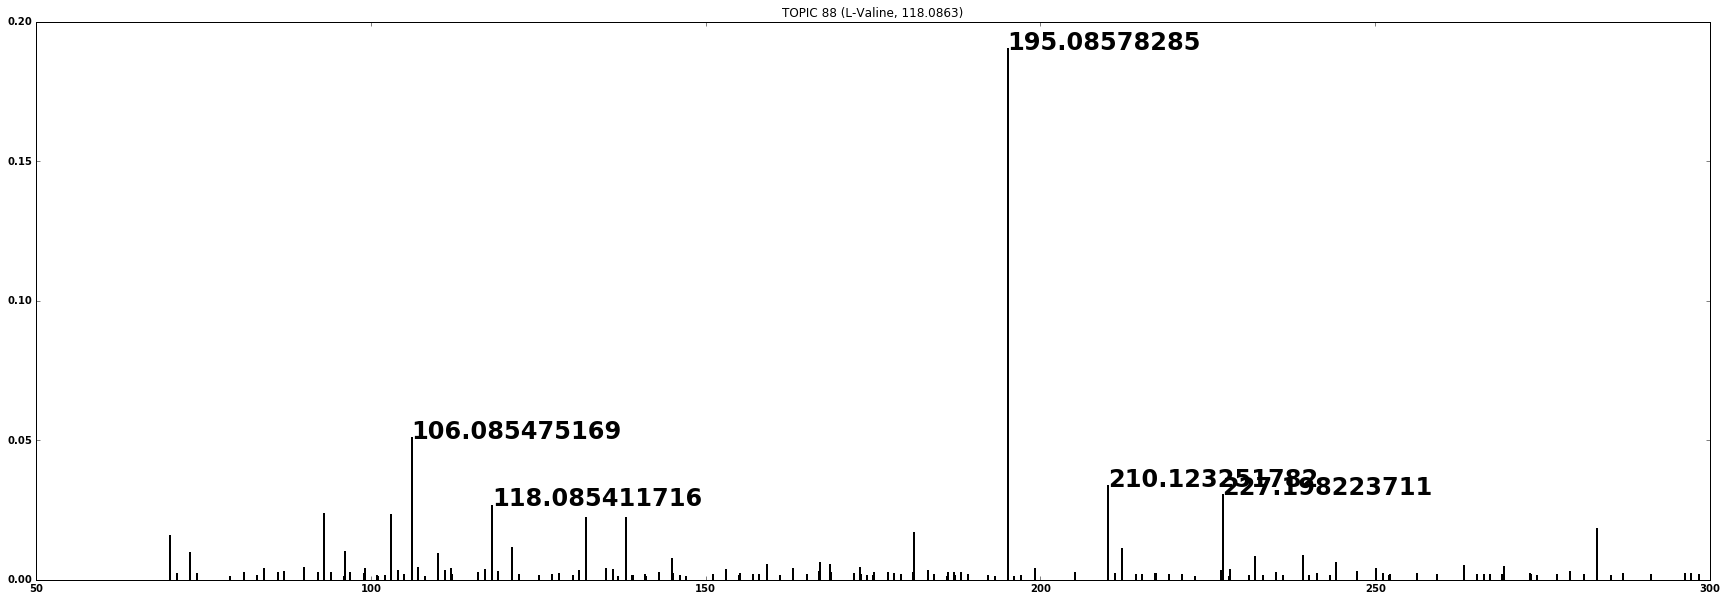

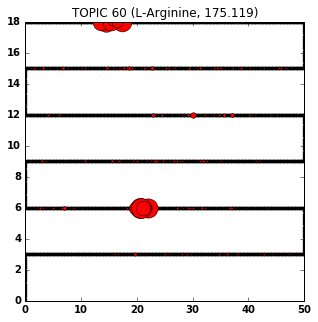

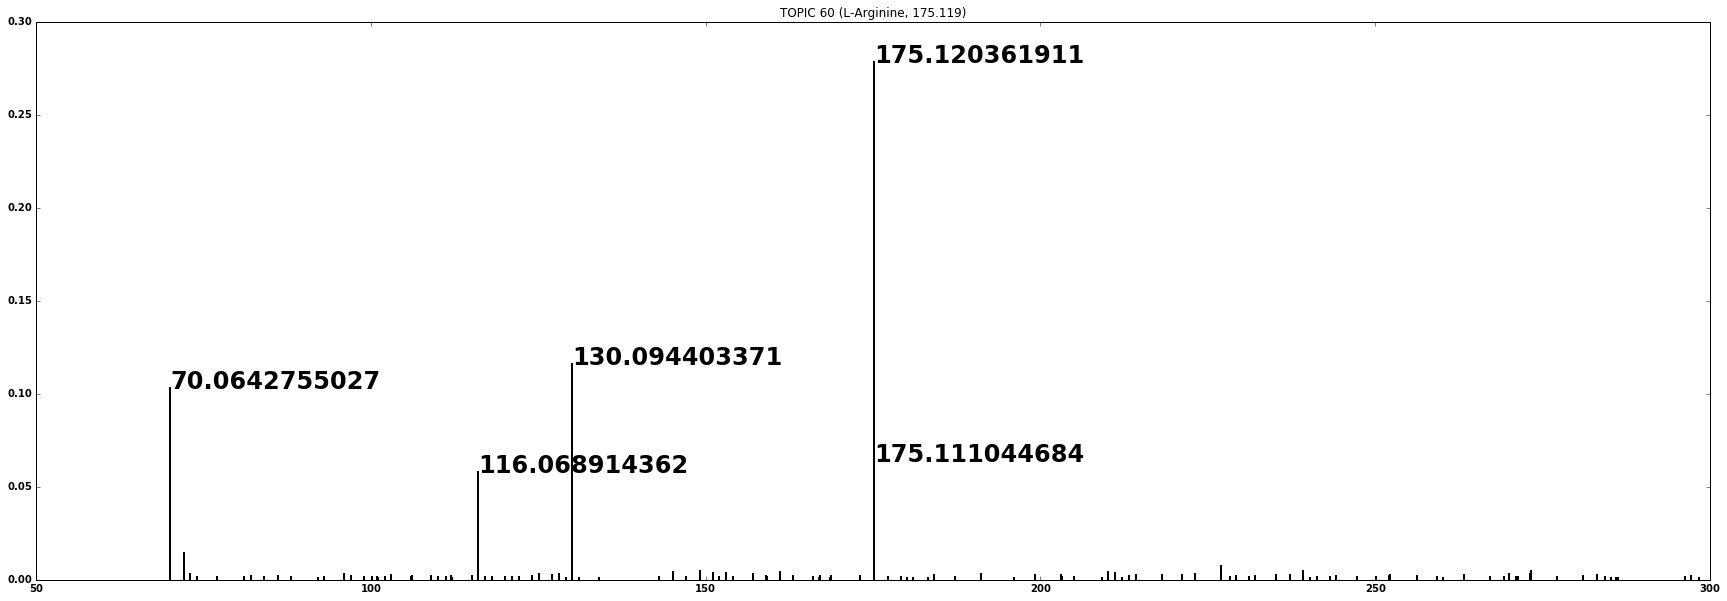

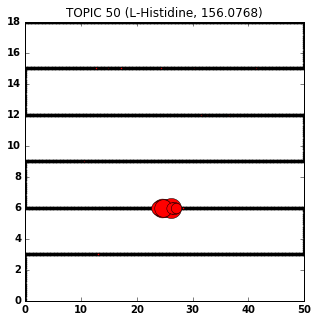

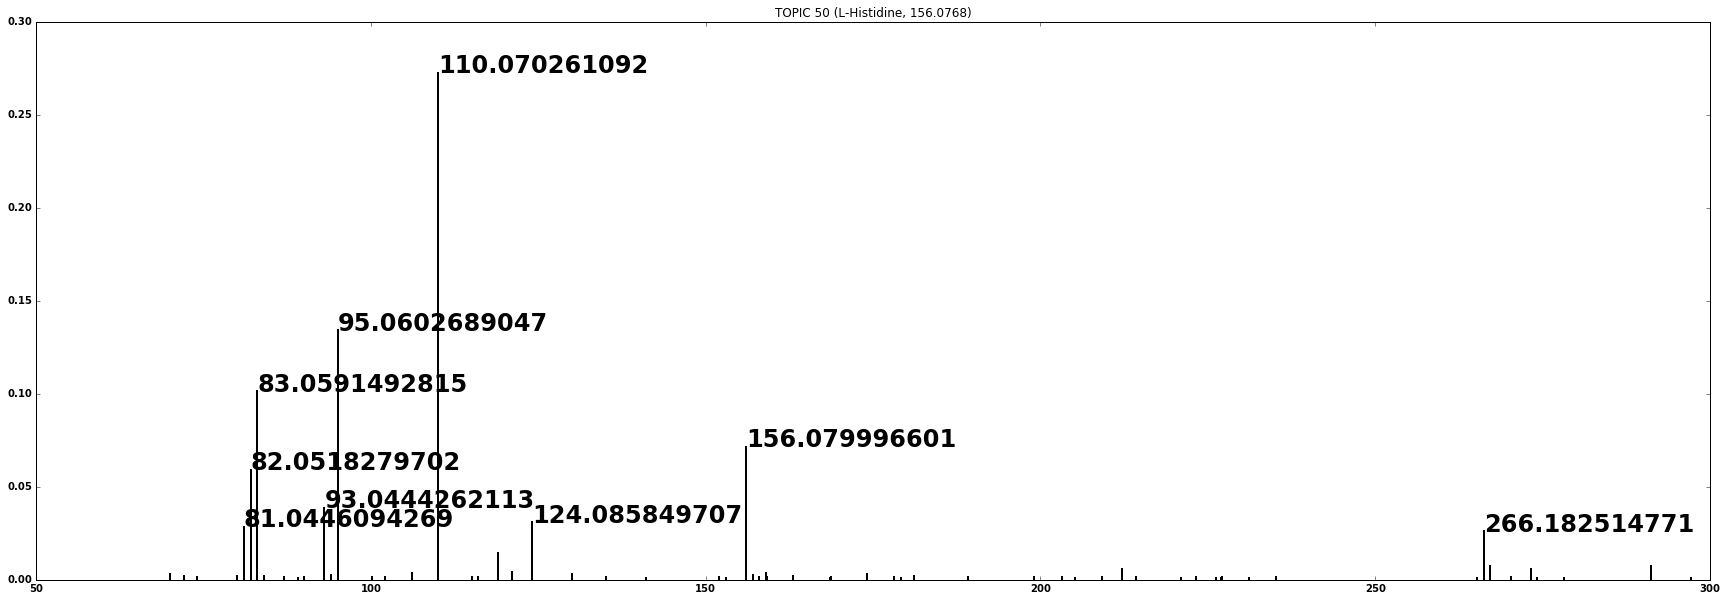

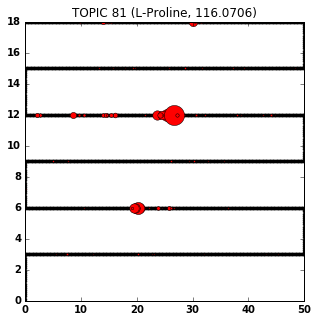

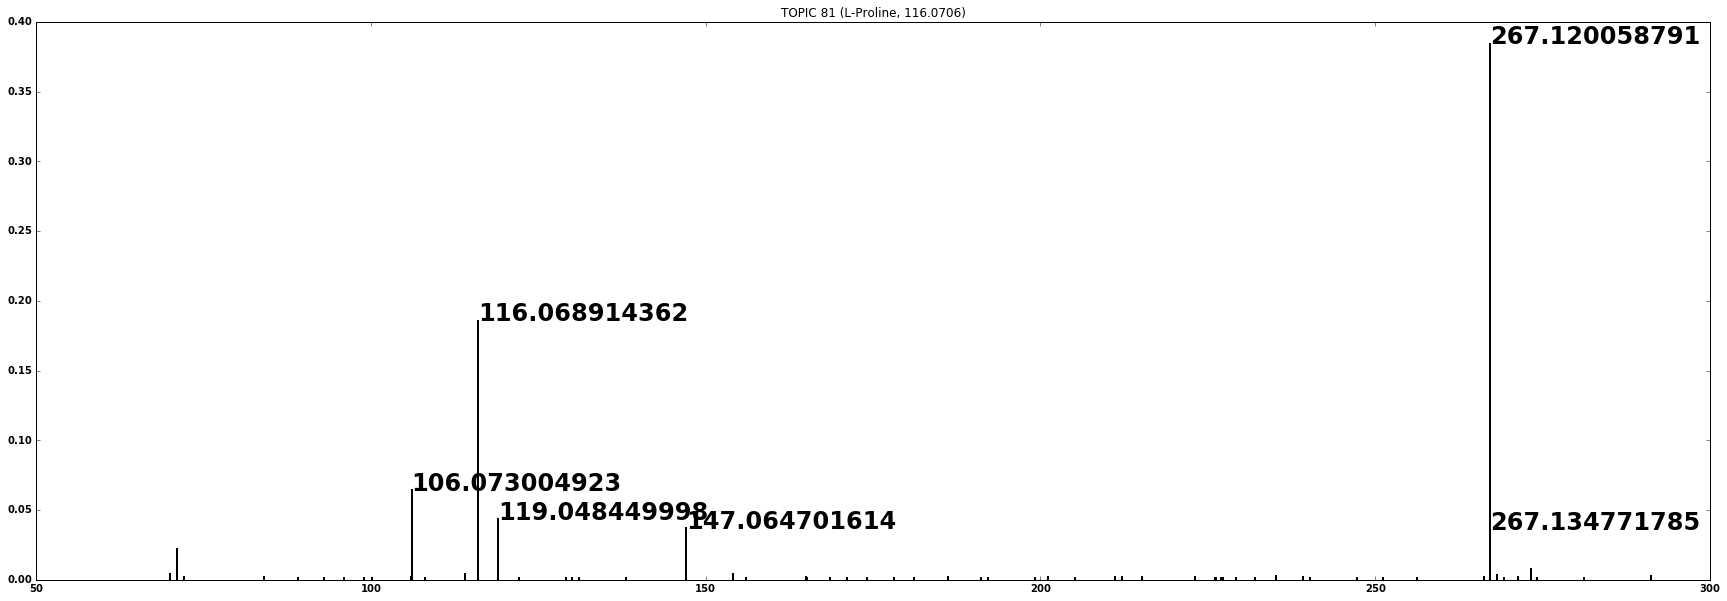

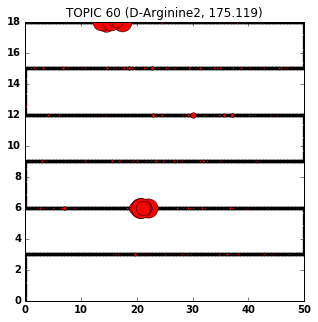

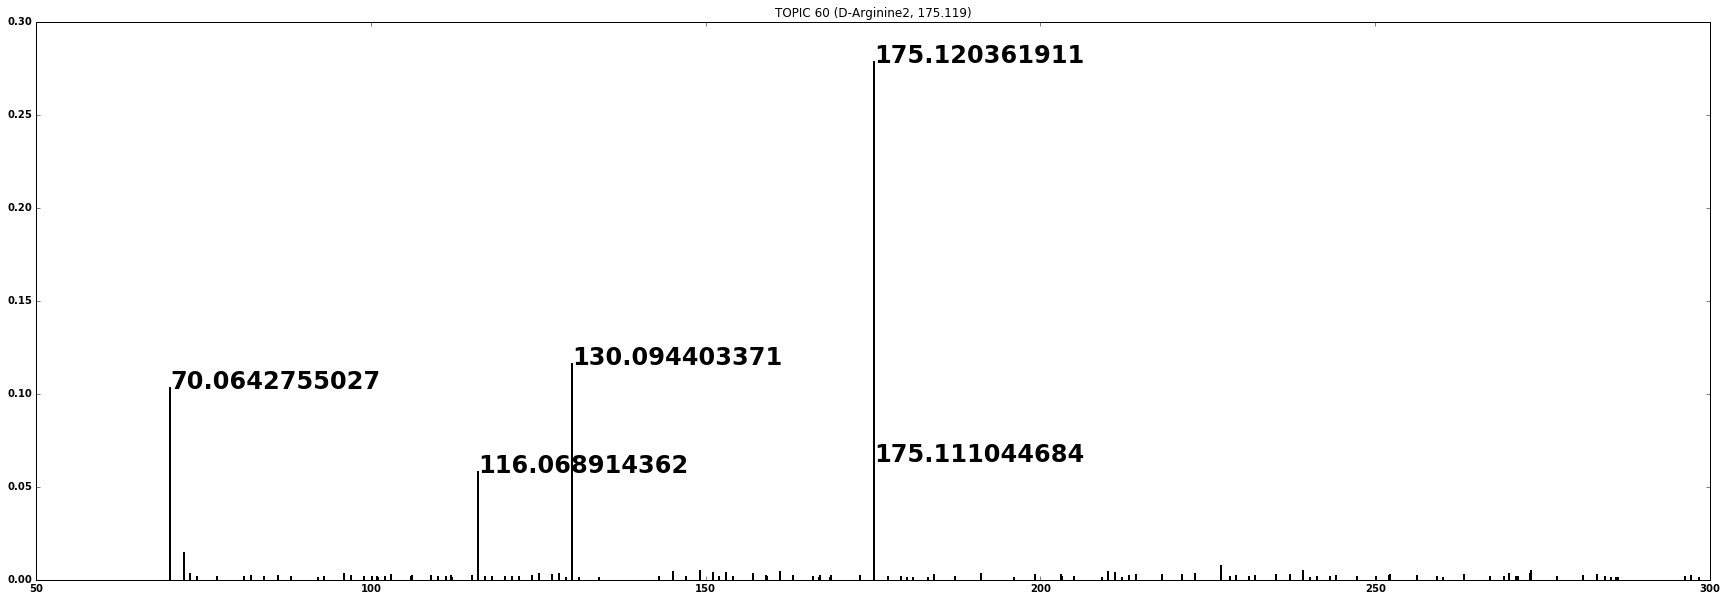

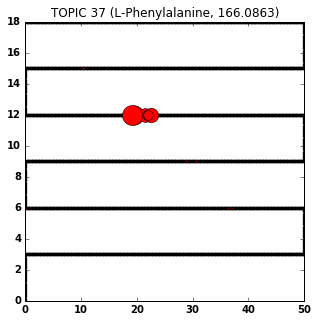

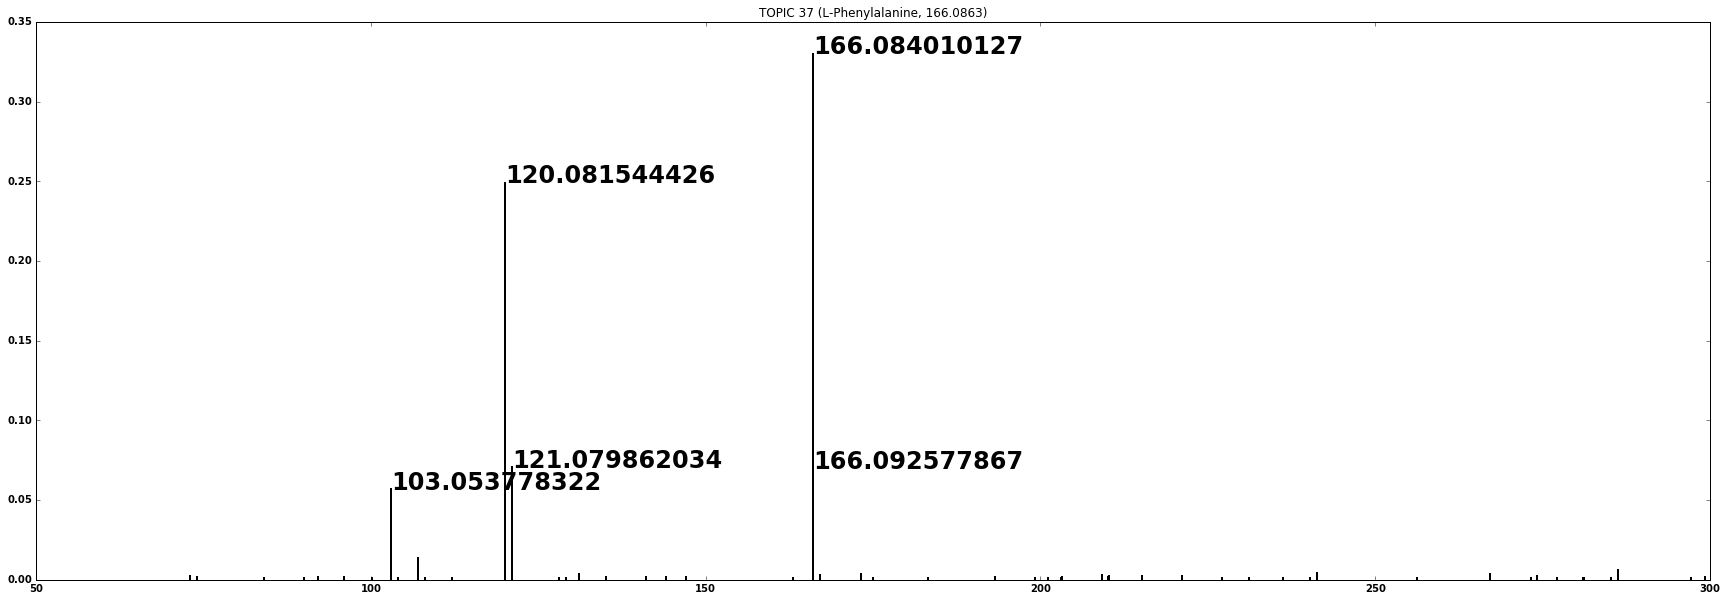

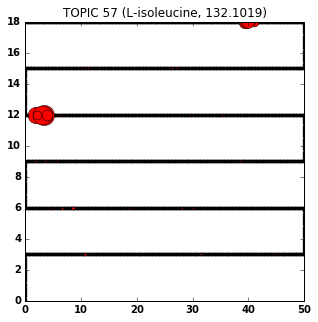

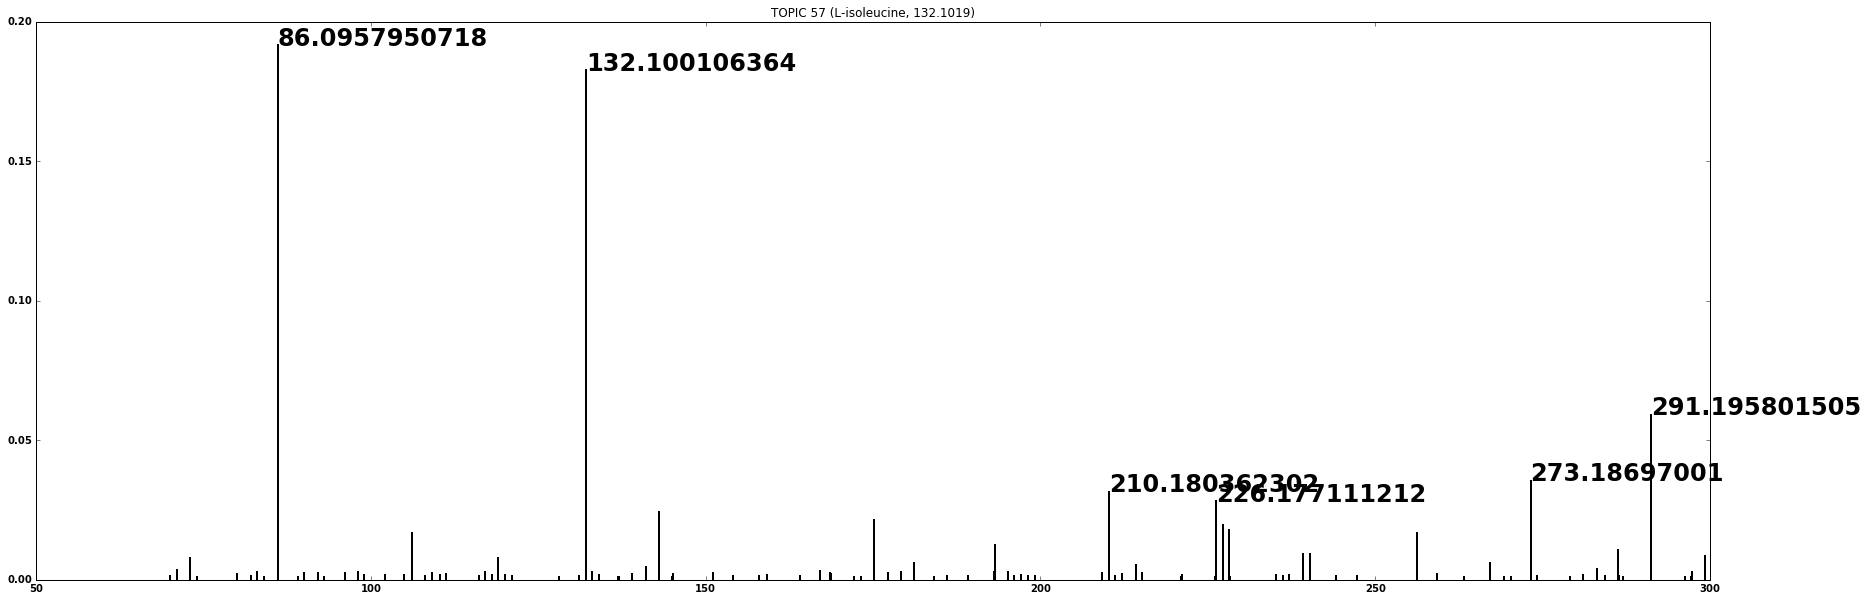

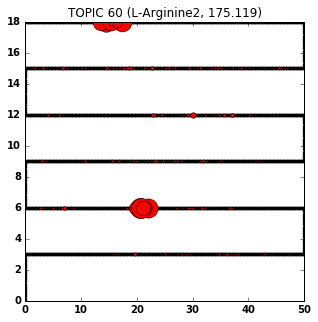

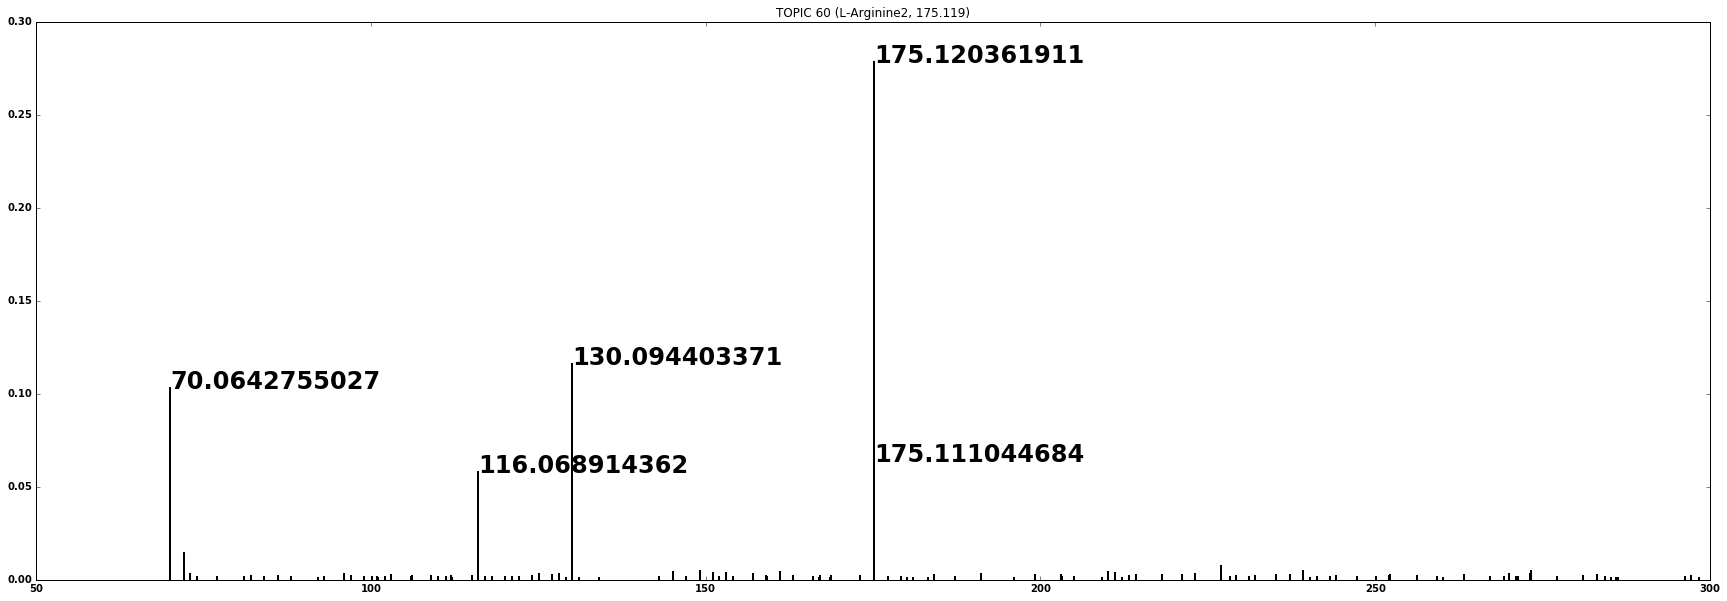

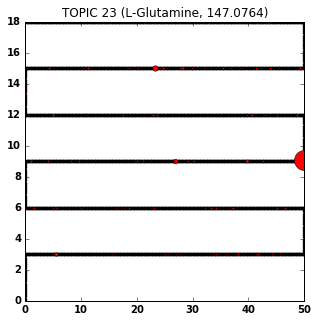

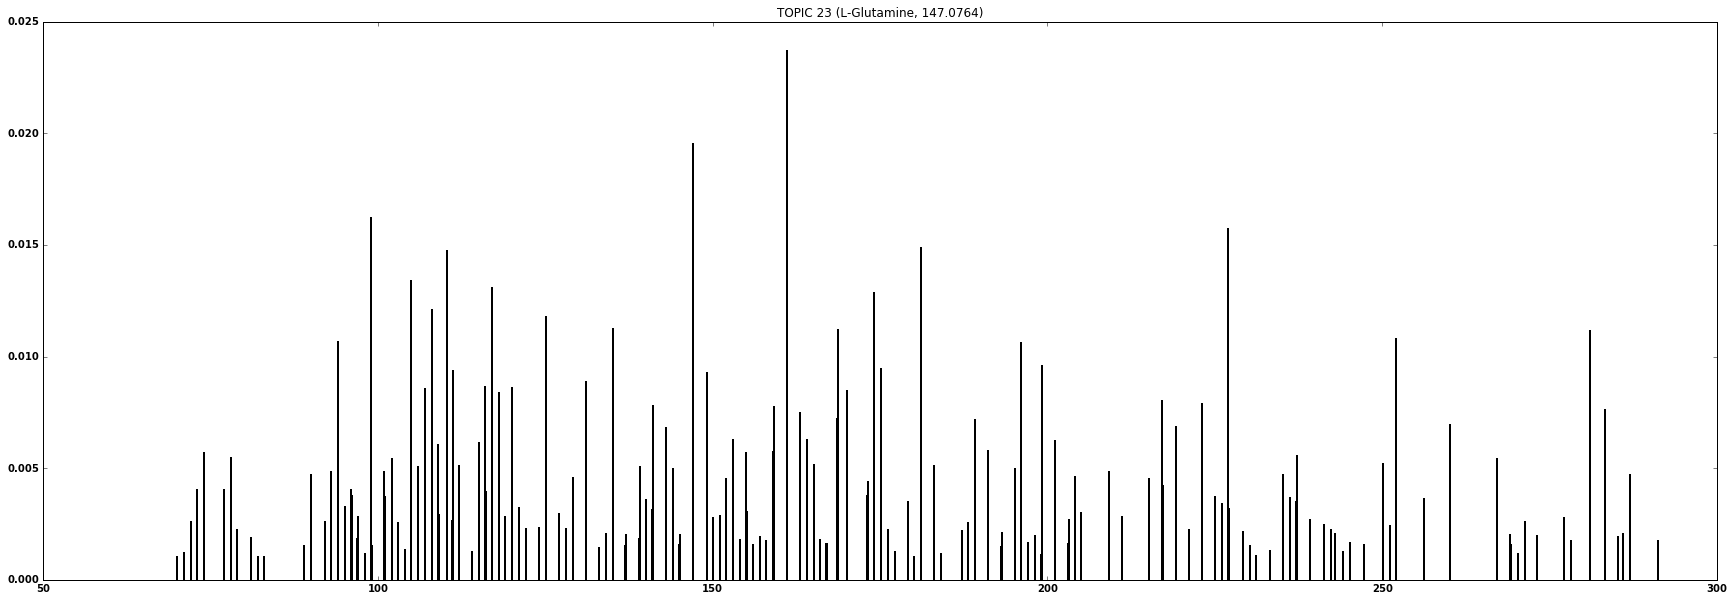

In [464]:
from ink_functions import plot_topic_dict
for a in best_topics:
    topic_of_interest = best_topics[a]
#     print
#     print
#     print "TOPIC {}".format(topic_of_interest)
    ig.plot(vals=l.get_topic_as_doc_dict(topic_of_interest),figsize=(5,5),max_marker_size=20)
    plt.title('TOPIC {} ({}, {})'.format(topic_of_interest,a,amino_acids[a]))
    plot_topic_dict(l.get_topic_as_dict(topic_of_interest),label_thresh=0.025)
    plt.title('TOPIC {} ({}, {})'.format(topic_of_interest,a,amino_acids[a]))
    
#     top = l.get_topic_as_tuples(topic_of_interest,thresh=0.01)
#     for t in top:
#         print t[0],t[1]

Find the topic most present in a particular block

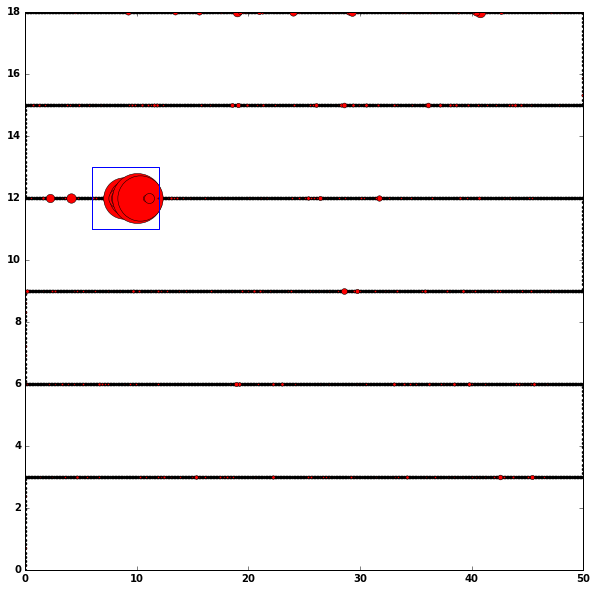

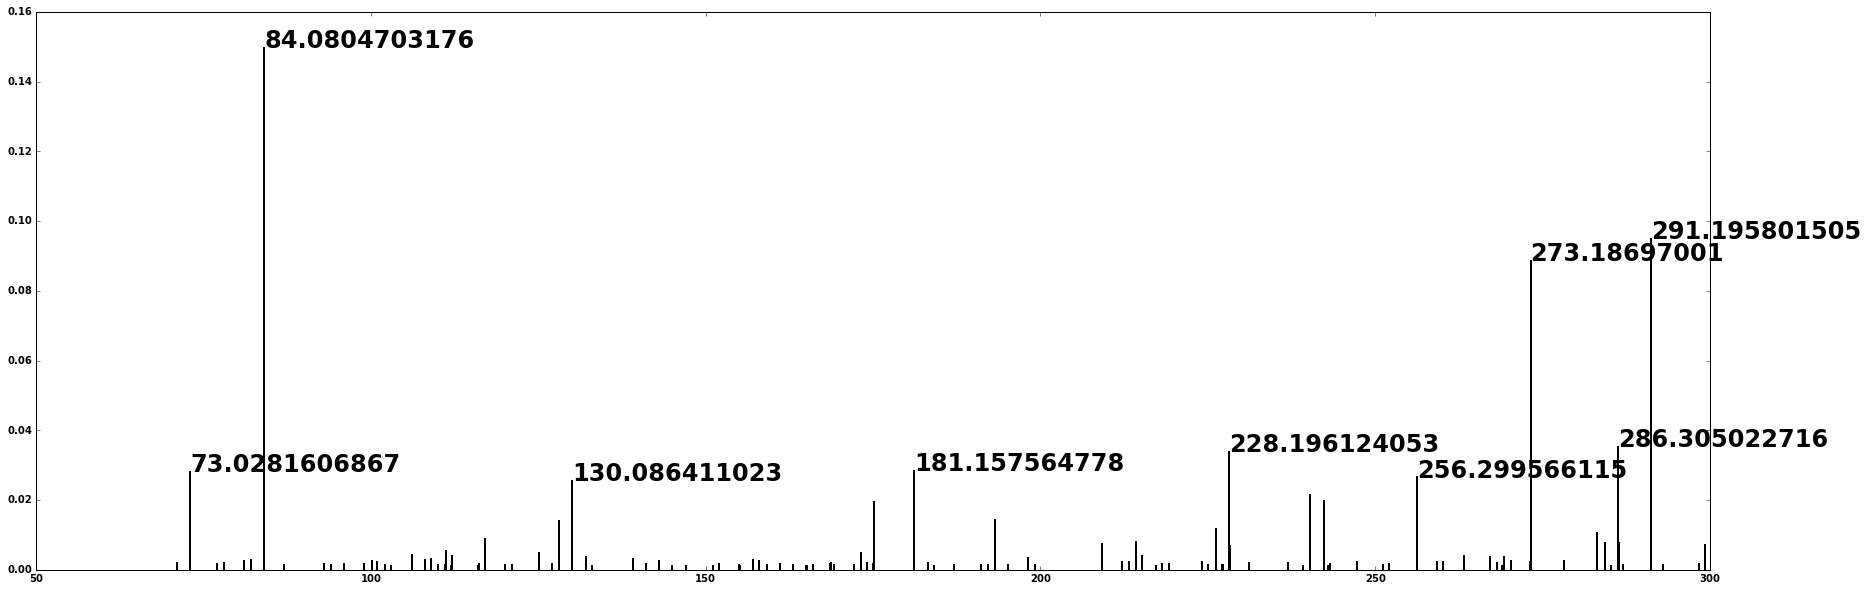

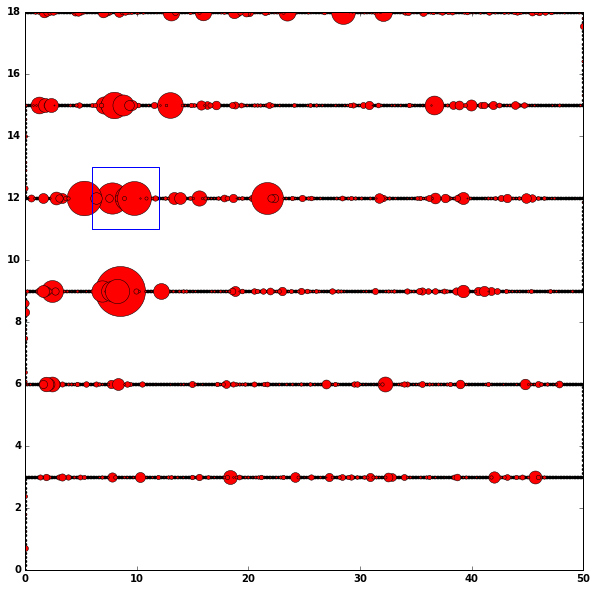

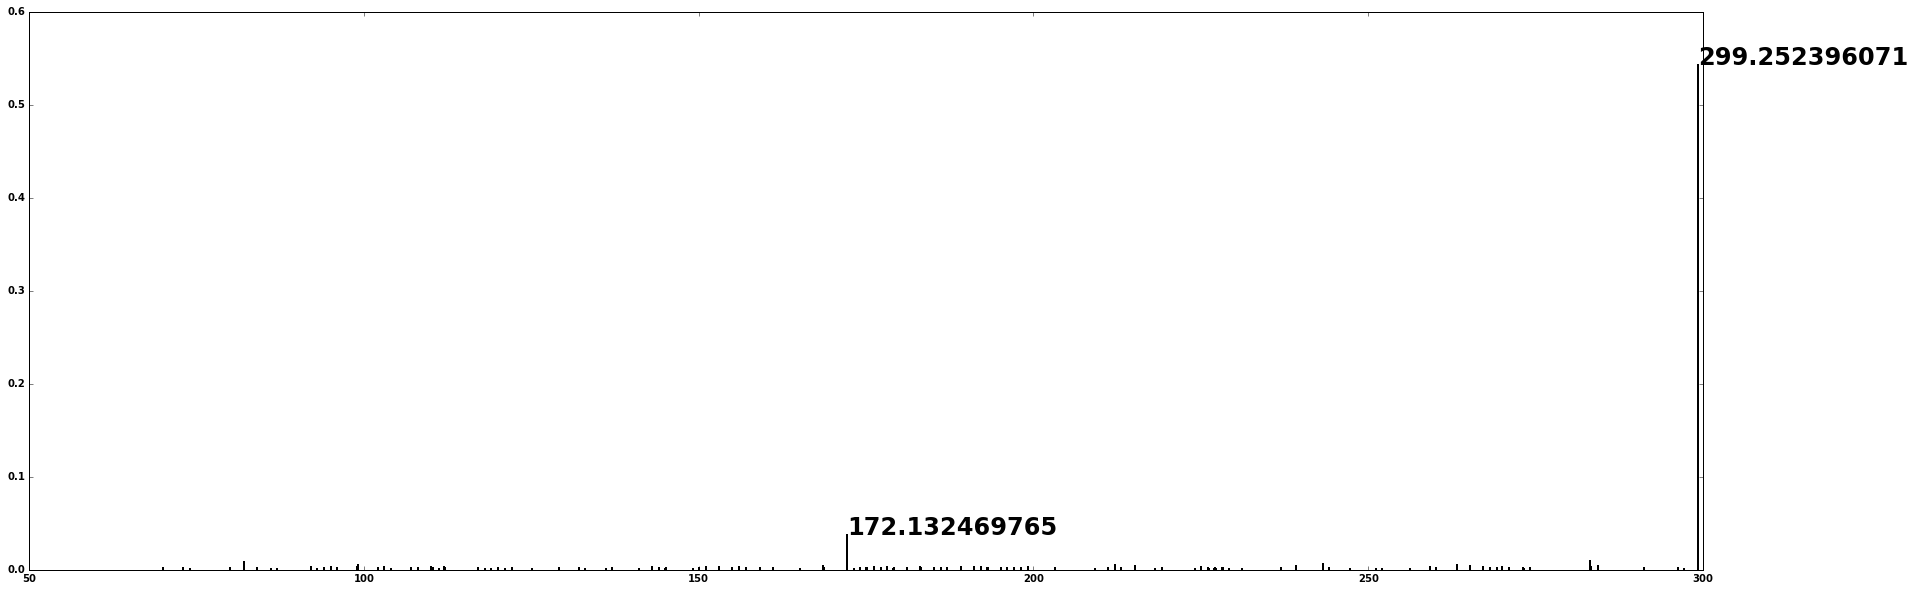

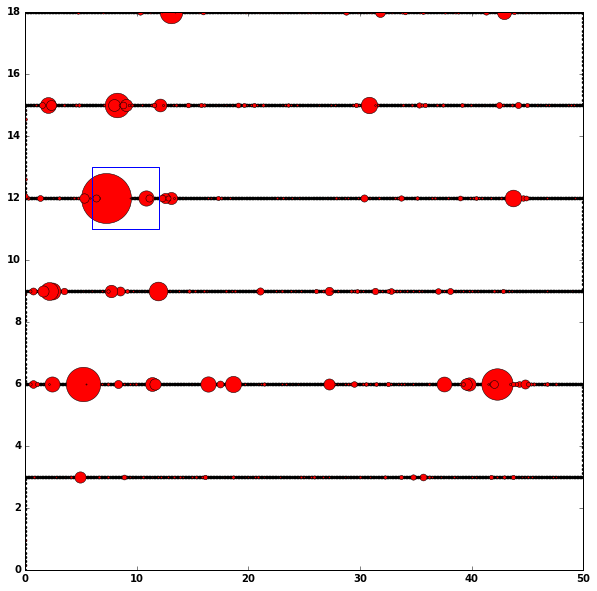

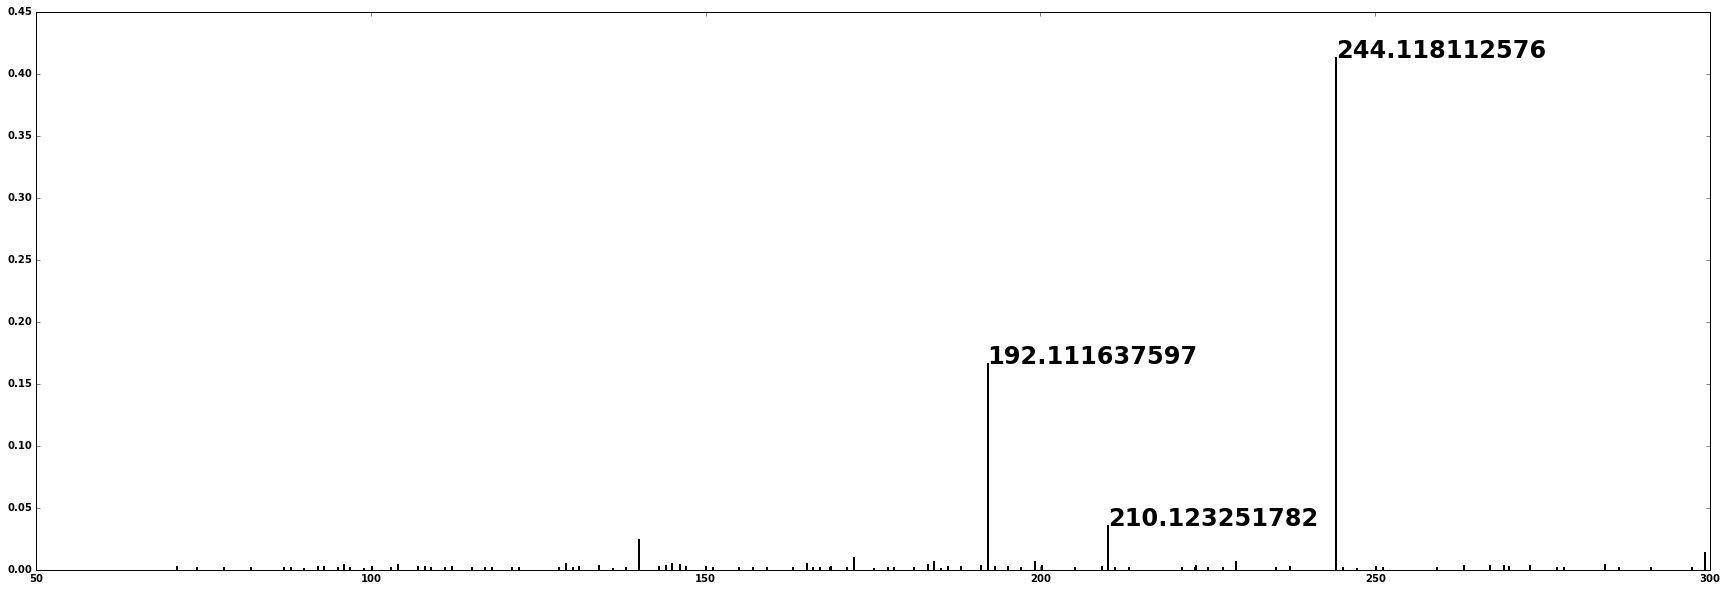

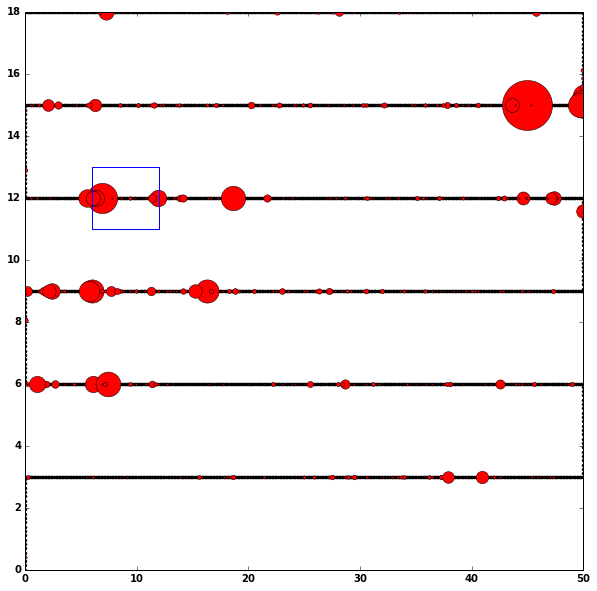

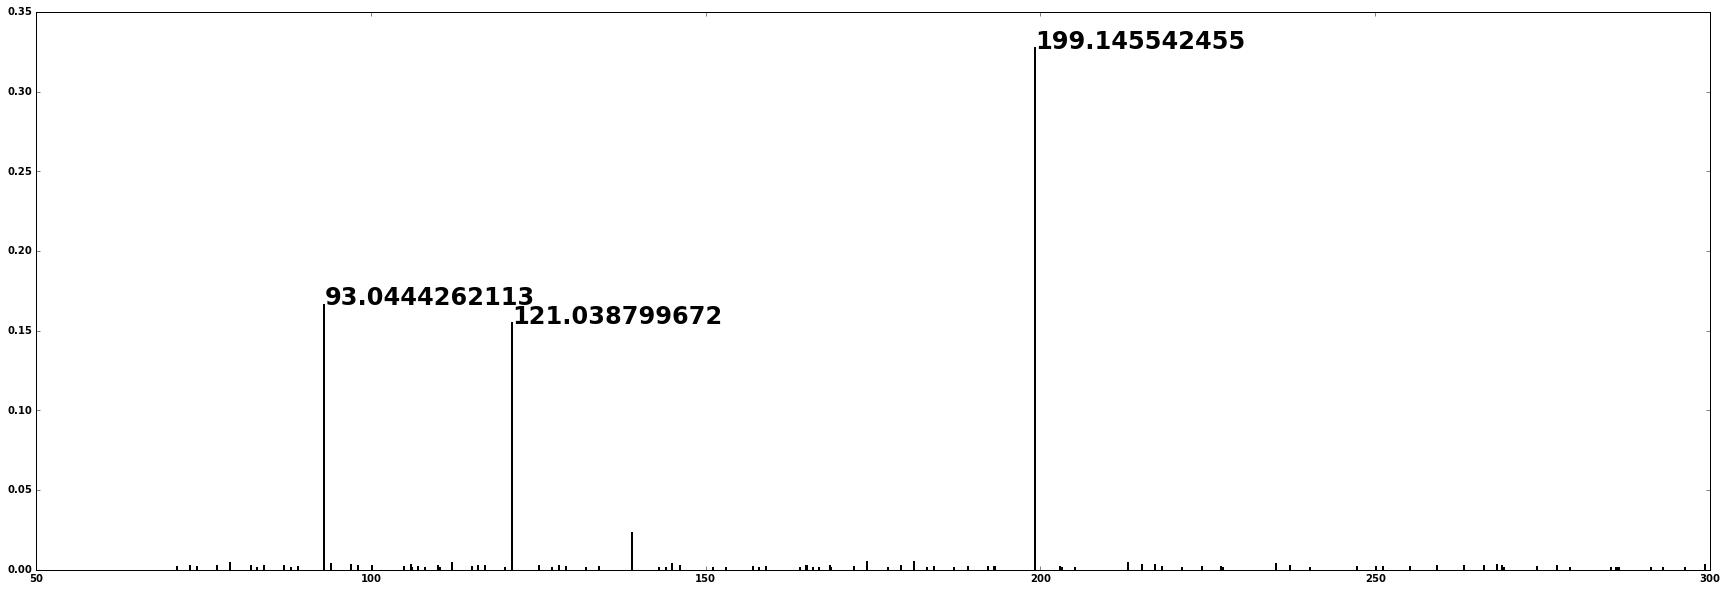

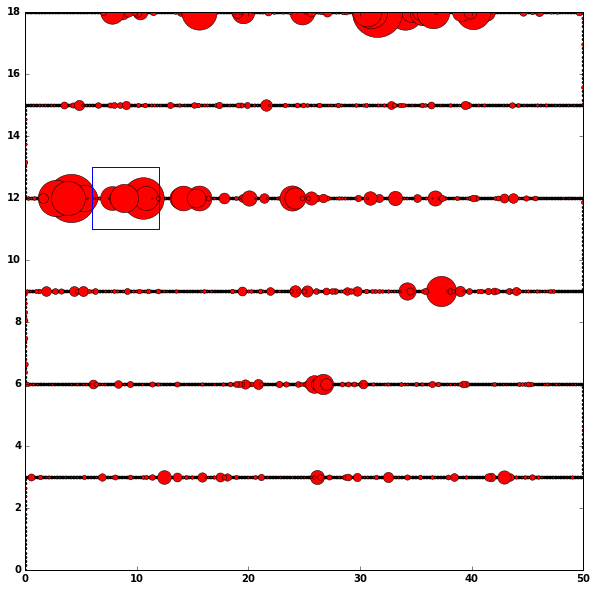

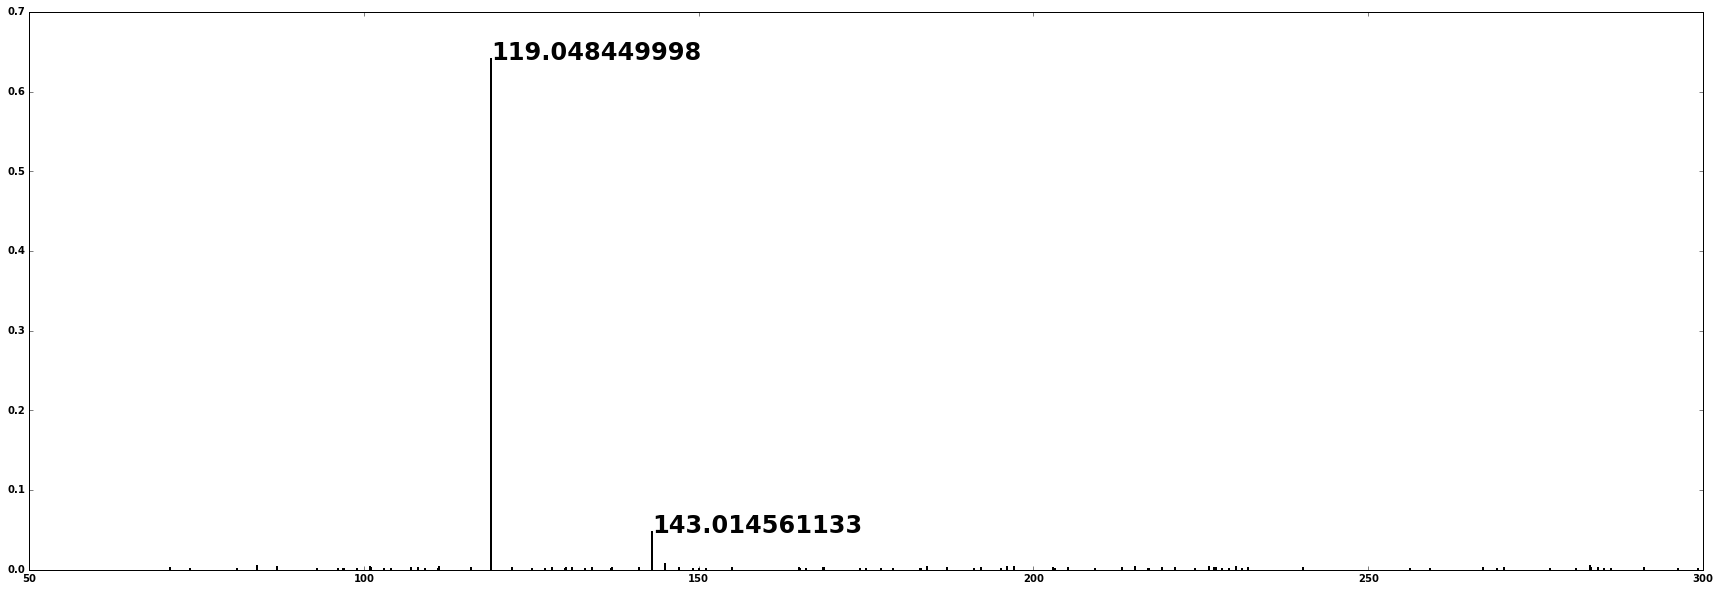

In [509]:
x_min = 6
x_max = 12
y_min = 11
y_max = 13
ok_docs = []
for i,x in enumerate(ig.colcoord):
    y = ig.rowcoord[i]
    if x >= x_min and x <= x_max and y >= y_min and y <= y_max:
        ok_docs.append(str(i))

total_topic_counts = l.doc_topic_counts.sum(axis=1)
ok_topic_counts = np.zeros_like(total_topic_counts)
for d in ok_docs:
    if d in l.doc_index:
        pos = l.doc_index[d]
        ok_topic_counts += l.doc_topic_counts[:,pos]

prop = 100.0*ok_topic_counts/total_topic_counts
for i in range(5):
    
    best_topic = prop.argmax()
    top = l.get_topic_as_doc_dict(best_topic)
    ig.plot(vals=top)
    plt.plot([x_min,x_max,x_max,x_min,x_min],[y_min,y_min,y_max,y_max,y_min],'b')
    prop[best_topic] = 0.0
    top = l.get_topic_as_dict(best_topic)
    plot_topic_dict(top,label_thresh=0.025)

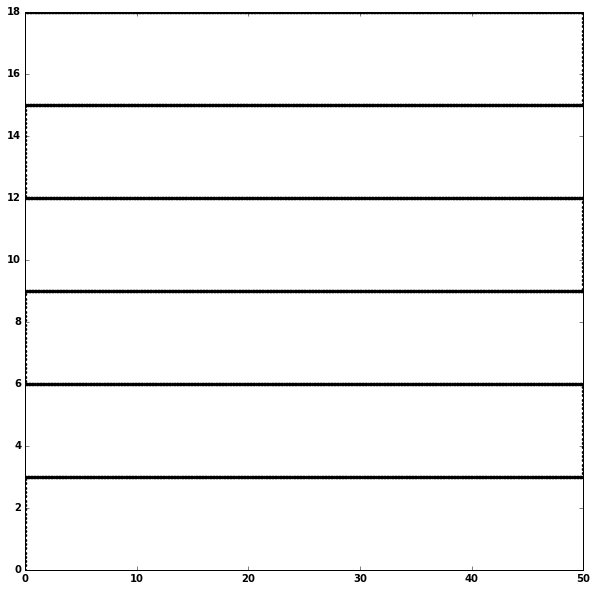

In [508]:
w = fe.word_names[sa]
v = {}
for d in fe.corpus:
    if w in fe.corpus[d]:
        v[d] = fe.corpus[d][w]
ig.plot(vals = v)

In [507]:
sa = np.abs(105.0 - np.array(fe.word_masses)).argmin()
print sa,fe.word_masses[sa]

331 104.998142478


In [367]:
def make_image(intense,rowcoord,colcoord,x_start = 0,x_end = 50,x_step=1,y_start=0,y_end=18,y_step=3):
    x_lower_vals = np.arange(x_start,x_end,x_step)
    y_lower_vals = np.arange(y_start,y_end,y_step)

    n_x = len(x_lower_vals)
    n_y = len(y_lower_vals)

    image = np.zeros((n_y,n_x),np.float)

    for k,yc in enumerate(rowcoord):
        if yc > y_lower_vals[-1]:
            y_in = n_y-1
        elif yc == y_lower_vals[0]:
            y_in = y_lower_vals[0]
        else:
            y_in = np.where(yc > y_lower_vals)[0][-1]
        xc = colcoord[k]
        if xc > x_lower_vals[-1]:
            x_in = n_x - 1
        elif xc == x_lower_vals[0]:
            x_in = x_lower_vals[0]
        else:
            x_in = np.where(xc > x_lower_vals)[0][-1]
        image[n_y-y_in-1,x_in] += intense[k]
    return image

In [510]:
print aa_file

/Users/simon/Dropbox/MS_Ink_Data/Amino Acids/AA_Array_2.mzML


In [7]:
def hit(m1,m2,tol):
    if 1e6*abs(m1-m2)/m1 < tol:
        return True
    else:
        return False